## Calculate the effect of the scene graph solver

the scene nodes are ordered, so the edge difference can be directly used to measure the difference between naively pick
the most probable edge or taking the whole graph into consideration

In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import h5py

In [2]:
def read_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def convert_to_nx(scene, directions, colors):
    graph = nx.MultiDiGraph()
    nodes = [(i, data) for i, data in enumerate(scene['objects'])]

    graph.add_nodes_from(nodes)
    for color, direction in zip(colors, directions):
        data = scene['relationships'][direction]
        for source, targets in enumerate(data):
            for target in targets:
                graph.add_edge(source, target, direction, color = color)
    return graph

In [3]:
scenes_edge = read_json('../data/scenes/scenes_with_rels.json')
scenes_graph = read_json('../data/scenes/scenes_with_rels_corrected.json')


In [4]:
directions = ['left', 'right', 'behind', 'front']
differences = {i: {'more': [], 'few': []} for i in range(len(scenes_graph['scenes']))}

for i, (scene_graph, scene_edge) in enumerate(zip(scenes_edge['scenes'], scenes_graph['scenes'])):
    for dire in directions:
        for source, (targets_graph, targets_edge) in enumerate(zip(scene_graph['relationships'][dire],
                                                                   scene_edge['relationships'][dire])):
            targets_graph = set(targets_graph)
            targets_edge = set(targets_edge)

            more = [(source, target, dire) for target in targets_graph.difference(targets_edge)]
            few = [(source, target, dire) for target in targets_edge.difference(targets_graph)]
            differences[i]['more'].extend(more)
            differences[i]['few'].extend(few)

differences = {key : value for (key, value) in differences.items() if len(value['more']) > 0 or len(value['few']) > 0}



In [5]:
for scene_id in differences.keys():
    print(scene_id)
    for direction in directions:
        graph = convert_to_nx(scenes_edge['scenes'][scene_id], [direction], ['r'])
        print(f'{direction} {list(nx.simple_cycles(graph))}')

19
left [[8, 1]]
right []
behind []
front []
82
left []
right []
behind []
front [[8, 7]]
226
left [[8, 6]]
right []
behind []
front []
230
left []
right []
behind []
front [[4, 5]]
233
left []
right [[4, 5]]
behind []
front []
234
left []
right []
behind [[4, 6]]
front []
273
left [[0, 9]]
right []
behind []
front []
339
left []
right [[3, 6]]
behind []
front []
356
left [[0, 5]]
right []
behind []
front []
417
left []
right []
behind []
front [[8, 2]]
440
left []
right []
behind []
front [[8, 7]]
441
left []
right []
behind []
front [[4, 6]]
472
left []
right []
behind [[8, 7]]
front []
474
left []
right []
behind [[4, 7]]
front []
501
left []
right [[1, 6]]
behind [[9, 4]]
front []
597
left []
right []
behind [[3, 5]]
front []
694
left []
right []
behind []
front [[2, 7]]
753
left []
right []
behind []
front [[8, 4]]
797
left []
right []
behind [[0, 7]]
front []
841
left []
right []
behind [[0, 4]]
front []
853
left []
right []
behind []
front [[0, 6]]


In [6]:
differences

{19: {'more': [(1, 8, 'left')], 'few': [(1, 8, 'right')]},
 82: {'more': [(8, 7, 'front')], 'few': [(8, 7, 'behind')]},
 226: {'more': [(8, 6, 'left')], 'few': [(8, 6, 'right')]},
 230: {'more': [(4, 5, 'front')], 'few': [(4, 5, 'behind')]},
 233: {'more': [(5, 4, 'right')], 'few': [(5, 4, 'left')]},
 234: {'more': [(4, 6, 'behind')], 'few': [(4, 6, 'front')]},
 273: {'more': [(0, 9, 'left')], 'few': [(0, 9, 'right')]},
 339: {'more': [(3, 6, 'right')], 'few': [(3, 6, 'left')]},
 356: {'more': [(0, 5, 'left')], 'few': [(0, 5, 'right')]},
 417: {'more': [(8, 2, 'front')], 'few': [(8, 2, 'behind')]},
 440: {'more': [(7, 8, 'front')], 'few': [(7, 8, 'behind')]},
 441: {'more': [(4, 6, 'front')], 'few': [(4, 6, 'behind')]},
 472: {'more': [(8, 7, 'behind')], 'few': [(8, 7, 'front')]},
 474: {'more': [(7, 4, 'behind')], 'few': [(7, 4, 'front')]},
 501: {'more': [(6, 1, 'right'), (4, 9, 'behind')],
  'few': [(6, 1, 'left'), (4, 9, 'front')]},
 597: {'more': [(3, 5, 'behind')], 'few': [(3, 5,

In [7]:
    # pos = nx.circular_layout(graph)
    # edges = graph.edges()
    #
    # colors = []
    # for u, v, data in list(graph.edges(data=True)):
    #     colors.append(data['color'])

# Fault Case Analysis

In [8]:
vocab = read_json('../data/vocab.json')
clevr_results = read_json('../data/reason/results/result_clevr.json')
clevr_rel_corrected_results = read_json('../data/reason/results/result_clevr_corrected.json')
questions = read_json('../data/Original/CLEVR_questions.json')['questions']
h5_filename = '../data/Original/images.h5'
images = h5py.File(h5_filename, 'r')['images']

In [9]:
wrong_ans_indexes = [i for (i, correct) in enumerate(clevr_results['corrects']) if not correct]
wrong_ans_indexes_rel_corrected = [i for (i, correct) in enumerate(clevr_rel_corrected_results['corrects']) if not correct]


2260
How many other objects are there of the same size as the cyan block?
{'image_index': 226, 'objects': [{'color': 'gray', 'shape': 'cylinder', 'material': 'rubber', 'size': 'large'}, {'color': 'cyan', 'shape': 'sphere', 'material': 'metal', 'size': 'large'}, {'color': 'blue', 'shape': 'cylinder', 'material': 'rubber', 'size': 'large'}, {'color': 'green', 'shape': 'sphere', 'material': 'rubber', 'size': 'small'}, {'color': 'purple', 'shape': 'cylinder', 'material': 'rubber', 'size': 'large'}, {'color': 'purple', 'shape': 'sphere', 'material': 'rubber', 'size': 'small'}, {'color': 'green', 'shape': 'cube', 'material': 'rubber', 'size': 'small'}, {'color': 'blue', 'shape': 'cube', 'material': 'rubber', 'size': 'small'}, {'color': 'cyan', 'shape': 'cylinder', 'material': 'metal', 'size': 'small'}], 'relationships': {'left': [[2, 4, 5, 6, 7, 8], [0, 2, 3, 4, 5, 6, 7, 8], [4], [0, 2, 4, 5, 6, 7, 8], [], [2, 4], [2, 4, 5, 7, 8], [2, 4, 5], [2, 4, 5, 7]], 'right': [[1, 3], [], [0, 1, 3, 5, 

['count',
 'same_size',
 'unique',
 'filter_shape[cube]',
 'filter_color[cyan]',
 'filter_color[cyan]',
 'filter_color[cyan]',
 'scene',
 '<END>',
 'equal_material',
 'equal_material',
 'equal_material',
 'equal_material',
 'equal_material',
 'equal_material',
 'equal_material',
 'equal_material',
 'equal_material',
 'equal_material',
 'equal_integer',
 'equal_integer',
 'equal_integer',
 'equal_integer',
 'query_material',
 'query_material',
 'query_material',
 'query_material']

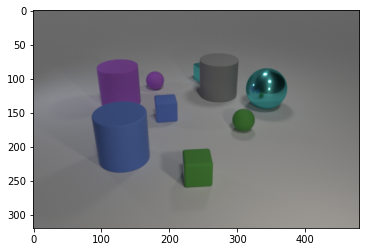

In [10]:
i = 2260
print(i)
print(questions[i]['question'])
print(scenes_graph['scenes'][questions[i]['image_index']])
print(len(scenes_graph['scenes'][questions[i]['image_index']]['objects']))
plt.imshow(images[questions[i]['image_index']])
print(f"Model Answer: {clevr_rel_corrected_results['answers'][i]}")
print(f"Actual Result: {questions[i]['answer']}")
[vocab['program_idx_to_token'][str(i)] for i in clevr_results['programs'][i]]

In [10]:
import itertools

list(itertools.product(*[[1, 2, 3], ['a', 'b', 'c']]))



[(1, 'a'),
 (1, 'b'),
 (1, 'c'),
 (2, 'a'),
 (2, 'b'),
 (2, 'c'),
 (3, 'a'),
 (3, 'b'),
 (3, 'c')]

In [177]:
set(wrong_ans_indexes_rel_corrected).difference(wrong_ans_indexes)

{5972}